This tutorial builds on Example1 and Example2 where all the processing
steps are explained in detail. We advise to run/read them first.
The aim of this example is to introduce users how to use GLMsingle
with BIDS formatted data. This data comes from an openneuro database 
"study forest" https://openneuro.org/datasets/ds000113/versions/1.3.0
from subj01 from an auditory perception task. To descrease
the processing time we have selected 1 slice of data (17).


In [1]:
import numpy as np
import scipy
import scipy.io as sio
import matplotlib.pyplot as plt
import nibabel
import pandas as pd
import os
from os.path import join, exists, split
import time
import urllib.request
import warnings
from tqdm import tqdm
from pprint import pprint
import zipfile
import glob
warnings.filterwarnings('ignore')

from glmsingle.glmsingle import GLM_single


### Set paths and download the example dataset

In [2]:
# get path to the directory to which GLMsingle was installed
homedir = split(os.getcwd())[0]

# create directory for saving data
datadir = join(homedir,'examples','data')
os.makedirs(datadir,exist_ok=True)

# create directory for saving outputs from example 1
outputdir = join(homedir,'examples','exampleBIDS')

print(f'directory to save example dataset:\n\t{datadir}\n')
print(f'directory to save example1 outputs:\n\t{outputdir}\n')

directory to save example dataset:
	/home/charestlab/GLMsingle/examples/data

directory to save example1 outputs:
	/home/charestlab/GLMsingle/examples/exampleBIDS



In [3]:
# download example dataset from GLMsingle OSF repository
# data comes from the NSD dataset (subj01, nsd01 scan session).
# see: https://www.biorxiv.org/content/10.1101/2021.02.22.432340v1.full.pdf

datafn = join(datadir,'BIDS.zip')

# to save time, we'll skip the download if the example dataset already exists on disk
if not exists(datafn):
    
    print(f'Downloading example dataset and saving to:\n{datafn}')
    
    dataurl = 'https://osf.io/deazx/download'
    
    # download the .mat file to the specified directory
    urllib.request.urlretrieve(dataurl, datafn)
    
# unzip struct containing example dataset

with zipfile.ZipFile(datafn, 'r') as zip_ref:
    zip_ref.extractall(datadir)
    
BIDS_folder = '%s/BIDS' %(datadir)
subj        = '01'
ses         = 'auditoryperception'
task        = 'auditoryperception'
tr          = 2
stimdur     = 6
datafolder  = '%s/subj-%s/ses-%s/func/' % (BIDS_folder,subj,ses)



/home/charestlab/GLMsingle/examples/data/BIDS.zip


In [5]:
# variables that will contain bold time-series

data = []

datafiles = np.sort([fn for fn in os.listdir(datafolder) if 'bold' in fn])

for d in tqdm(range(len(datafiles))):
    
    tmp = nibabel.load(os.path.join(datafolder,datafiles[d]))
    data.append(tmp.get_fdata())
    
xyz = data[0].shape[:3]



100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 20.31it/s]


In [8]:
# variable that will contain design matrices
import pandas as pd

design = []

eventfiles = np.sort([fn for fn in os.listdir(datafolder) if 'events' in fn])
conds = np.array(['ambient','country','metal','rocknroll','symphonic'])
nconds = 5

for e in (range(len(eventfiles))):
    run_events = pd.read_csv(os.path.join(datafolder,eventfiles[e]),delimiter = '\t')
    run_design = np.zeros((np.shape(data)[4], nconds))
    for c, cond in enumerate(conds):
            condidx = np.argwhere(run_events['trial_type'].values == cond)
            condvols = run_events['run_volume'].values[condidx]
            run_design[condvols, c] = 1
    design.append(run_design)
            


In [9]:
# create a directory for saving GLMsingle outputs
outputdir_glmsingle = join(homedir,'examples','exampleBIDS','GLMsingle')

opt = dict()

# set important fields for completeness (but these would be enabled by default)
opt['wantlibrary'] = 1
opt['wantglmdenoise'] = 1
opt['wantfracridge'] = 1

# for the purpose of this example we will keep the relevant outputs in memory
# and also save them to the disk
opt['wantfileoutputs'] = [1,1,1,1]
opt['wantmemoryoutputs'] = [1,1,1,1]

# running python GLMsingle involves creating a GLM_single object
# and then running the procedure using the .fit() routine
glmsingle_obj = GLM_single(opt)

# visualize all the hyperparameters
pprint(glmsingle_obj.params)

{'R2thresh': 0,
 'brainR2': [],
 'brainexclude': False,
 'brainthresh': [99.0, 0.1],
 'chunklen': 50000,
 'extra_regressors': False,
 'firdelay': 30,
 'firpct': 99,
 'fracs': array([1.  , 0.95, 0.9 , 0.85, 0.8 , 0.75, 0.7 , 0.65, 0.6 , 0.55, 0.5 ,
       0.45, 0.4 , 0.35, 0.3 , 0.25, 0.2 , 0.15, 0.1 , 0.05]),
 'hrffitmask': 1,
 'hrfmodel': 'optimise',
 'hrfthresh': 0.5,
 'lambda': 0,
 'n_boots': 100,
 'n_jobs': 1,
 'n_pcs': 10,
 'numforhrf': 50,
 'pcR2cutoff': [],
 'pcR2cutoffmask': 1,
 'pcstop': 1.05,
 'seed': 1698112378.705975,
 'suppressoutput': 0,
 'wantautoscale': 1,
 'wantfileoutputs': [1, 1, 1, 1],
 'wantfracridge': 1,
 'wantglmdenoise': 1,
 'wanthdf5': 0,
 'wantlibrary': 1,
 'wantlss': 0,
 'wantmemoryoutputs': [1, 1, 1, 1],
 'wantparametric': 0,
 'wantpercentbold': 1}


In [10]:
start_time = time.time()


if not exists(outputdir_glmsingle):

    print(f'running GLMsingle...')
    
    # run GLMsingle
    results_glmsingle = glmsingle_obj.fit(
       design,
       data,
       stimdur,
       tr,
       outputdir=outputdir_glmsingle)
    
    # we assign outputs of GLMsingle to the "results_glmsingle" variable.
    # note that results_glmsingle['typea'] contains GLM estimates from an ONOFF model,
    # where all images are treated as the same condition. these estimates
    # could be potentially used to find cortical areas that respond to
    # visual stimuli. we want to compare beta weights between conditions
    # therefore we are not going to include the ONOFF betas in any analyses of 
    # voxel reliability
    
else:
    print(f'loading existing GLMsingle outputs from directory:\n\t{outputdir_glmsingle}')
    
    # load existing file outputs if they exist
    results_glmsingle = dict()
    results_glmsingle['typea'] = np.load(join(outputdir_glmsingle,'TYPEA_ONOFF.npy'),allow_pickle=True).item()
    results_glmsingle['typeb'] = np.load(join(outputdir_glmsingle,'TYPEB_FITHRF.npy'),allow_pickle=True).item()
    results_glmsingle['typec'] = np.load(join(outputdir_glmsingle,'TYPEC_FITHRF_GLMDENOISE.npy'),allow_pickle=True).item()
    results_glmsingle['typed'] = np.load(join(outputdir_glmsingle,'TYPED_FITHRF_GLMDENOISE_RR.npy'),allow_pickle=True).item()

elapsed_time = time.time() - start_time

print(
    '\telapsed time: ',
    f'{time.strftime("%H:%M:%S", time.gmtime(elapsed_time))}'
)

running GLMsingle...
*** DIAGNOSTICS ***:
There are 8 runs.
The number of conditions in this experiment is 5.
The stimulus duration corresponding to each trial is 6.00 seconds.
The TR (time between successive data points) is 2.00 seconds.
The number of trials in each run is: [25, 25, 25, 25, 25, 25, 25, 25].
The number of trials for each condition is: [40, 40, 40, 40, 40].
For each condition, the number of runs in which it appears: [8, 8, 8, 8, 8].
For each run, how much ending buffer do we have in seconds? [16, 16, 18, 16, 18, 16, 18, 14].
*** Saving design-related results to /home/charestlab/GLMsingle/examples/exampleBIDS/GLMsingle/DESIGNINFO.npy. ***
*** FITTING DIAGNOSTIC RUN-WISE FIR MODEL ***
*** Saving FIR results to /home/charestlab/GLMsingle/examples/exampleBIDS/GLMsingle/RUNWISEFIR.npy. ***

*** FITTING TYPE-A MODEL (ONOFF) ***

fitting model...
done.

preparing output...
done.

computing model fits...
done.

computing R^2...
done.

computing SNR...
done.


*** Saving results

chunks: 100%|█████████████████████████████████████| 1/1 [00:23<00:00, 23.83s/it]



*** Saving results to /home/charestlab/GLMsingle/examples/exampleBIDS/GLMsingle/TYPEB_FITHRF.npy. ***

*** DETERMINING GLMDENOISE REGRESSORS ***

*** CROSS-VALIDATING DIFFERENT NUMBERS OF REGRESSORS ***



chunks: 100%|█████████████████████████████████████| 1/1 [00:36<00:00, 36.83s/it]



*** FITTING TYPE-C MODEL (GLMDENOISE) ***



chunks: 100%|█████████████████████████████████████| 1/1 [00:06<00:00,  6.89s/it]



*** Saving results to /home/charestlab/GLMsingle/examples/exampleBIDS/GLMsingle/TYPEC_FITHRF_GLMDENOISE.npy. ***

*** FITTING TYPE-D MODEL (GLMDENOISE_RR) ***



chunks: 100%|████████████████████████████████████| 1/1 [01:48<00:00, 108.75s/it]


*** Saving results to /home/charestlab/GLMsingle/examples/exampleBIDS/GLMsingle/TYPED_FITHRF_GLMDENOISE_RR.npy. ***

*** All model types done ***

*** return model types in results ***

	elapsed time:  00:02:59


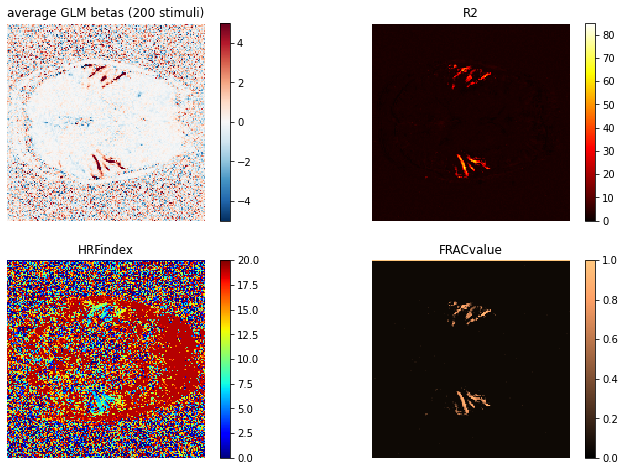

In [9]:
# we are going to plot several outputs from the FIT_HRF_GLMdenoise_RR GLM,
# which contains the full set of GLMsingle optimizations.

# we will plot betas, R2, optimal HRF indices, and the voxel frac values
plot_fields = ['betasmd','R2','HRFindex','FRACvalue']
colormaps = ['RdBu_r','hot','jet','copper']
clims = [[-5,5],[0,85],[0,20],[0,1]]

plt.figure(figsize=(12,8))

for i in range(len(plot_fields)):
    
    plt.subplot(2,2,i+1)
    
    if i == 0:
        # when plotting betas, for simplicity just average across all image presentations
        # this will yield a summary of whether voxels tend to increase or decrease their 
        # activity in response to the experimental stimuli (similar to outputs from 
        # an ONOFF GLM)
        plot_data = np.nanmean(np.squeeze(results_glmsingle['typed'][plot_fields[i]]),2)
        titlestr = 'average GLM betas (200 stimuli)'
    
    else:
        # plot all other voxel-wise metrics as outputted from GLMsingle
        plot_data = np.squeeze(results_glmsingle['typed'][plot_fields[i]].reshape(xyz))
        titlestr = plot_fields[i]
    
    plt.imshow(plot_data,cmap=colormaps[i],clim=clims[i],interpolation='nearest')
    plt.colorbar()
    plt.title(titlestr)
    plt.axis(False)